### Grafico la curva de abundance matching

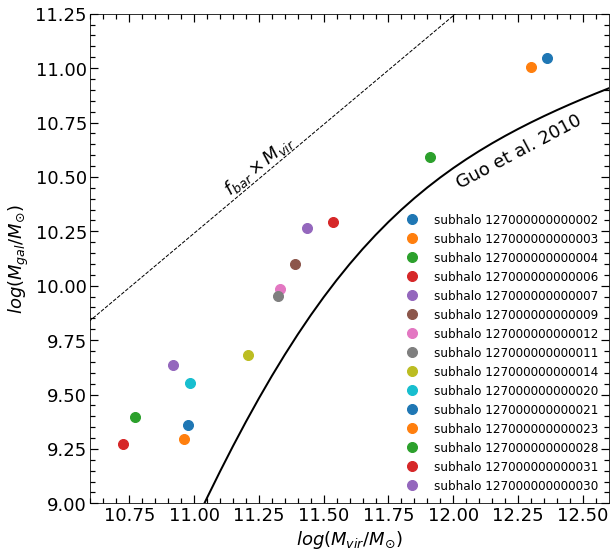

In [11]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
import gc
import time_conversion as time
import random

G = 4.299e-6

#-----------------CURVA DE GOU-----------------------------
c = 0.129
M0 = 10**11.4
alpha = 0.926
beta = 0.261
gamma = 2.440
MM = np.arange(11,13,0.05)
M_vir = 10**MM

#------------------curva de Guo et al 2010-------------------
c1 = (M_vir/M0)**(-alpha)
c2 = (M_vir/M0)**beta
M_estrella = M_vir * c * ((c1+c2)**(-gamma))

Me=np.log10(M_estrella)

#-------fraccion de bariones universal--------------------
MM1 = np.arange(10.5, 13, 0.05)
fbar = 0.0418/0.24
Mbar = fbar * 10**MM1
#--------------------------------------------------

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
fig.subplots_adjust(bottom=0.10, left =0.08, right = 0.98, top = 0.95,hspace=0.05)

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '/z/omarioni/gradients/_simulations/snap_127/'

for j in range(15):
    
    snap = h5py.File(path + 'subhalo_'+str('%d'%ID[j])+'.h5py', 'r')

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]
    Rvir = snap['/R200'][()]

    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]
    vstr = snap['/Str/Velocities'][()]
    sft  = snap['/Str/FormationTime'][()]

    pgas = snap['/Gas/Coordinates'][()]
    mgas = snap['/Gas/Masses'][()]

    pdrk = snap['/Drk/Coordinates'][()]
    mdrk = snap['/Drk/Masses'][()]

    amask, = np.where(sft>0)#aca puede haber particulas con age<0, esas no son estrellas son gas cells.
    emask, = np.where(sft<0)
    ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
    age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)

    #---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = pstr[amask,0]*aexp/h
    ystr = pstr[amask,1]*aexp/h
    zstr = pstr[amask,2]*aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    xgas = pgas[:,0]*aexp/h
    ygas = pgas[:,1]*aexp/h
    zgas = pgas[:,2]*aexp/h
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

    xdrk = pdrk[:,0]*aexp/h
    ydrk = pdrk[:,1]*aexp/h
    zdrk = pdrk[:,2]*aexp/h
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

    #----------------------masas----------------------------
    mstr = mstr[amask]*1e10/h
    mgas = mgas*1e10/h
    mdrk = mdrk*1e10/h
    
    R200 = Rvir*aexp/h
    rgal = 0.15*R200

    limit_str   = np.where(rstr<rgal)
    Mstr = np.sum((mstr[limit_str]))
   
    rtot = np.concatenate([rstr, rgas, rdrk])
    mtot = np.concatenate([mstr, mgas, mdrk])

    limit_tot   = np.where(rtot<R200)
    Mtot = np.sum((mtot[limit_tot]))
#---------------------------------------------------------
    ax.plot(np.log10(Mtot), np.log10(Mstr),'o',markersize = 10, label='subhalo '+str('%d'%ID[j]))

ax.plot(MM, Me, color='k', lw=2)
ax.plot(MM1, np.log10(Mbar),'--', lw=1, color ='k')
ax.set_ylim(9.0,11.25)
ax.set_xlim(10.6,12.6)
ax.minorticks_on()
ax.tick_params( labelsize=18)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on')
ax.set_xlabel(r'$log(M_{vir}/M_{\odot})$', fontsize=18)
ax.set_ylabel(r'$log(M_{gal}/M_{\odot})$', fontsize=18)
ax.text(11.1,10.42, r'$f_{bar} \times M_{vir}$', rotation=39, fontsize=18)
ax.text(12,10.45, 'Guo et al. 2010', rotation=28, fontsize=18)
ax.legend(frameon=False, fontsize=12)

fig.savefig('../_imagenes/Mvir_vs_Mgal.png', dpi = 100)
plt.show()

#### Checkeo cuanta masa de particulas con tiempo de formacion<0 hay 

In [6]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
import gc
import time_conversion as time
import random

G = 4.299e-6

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '/z/omarioni/gradients/_simulations/snap_127/'

for j in range(15):
    
    snap = h5py.File(path + 'subhalo_'+str('%d'%ID[j])+'.h5py', 'r')
    print('subhalo', str('%d'%ID[j]))

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]
    Rvir = snap['/R200'][()]

    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]
    vstr = snap['/Str/Velocities'][()]
    sft  = snap['/Str/FormationTime'][()]

    pgas = snap['/Gas/Coordinates'][()]
    mgas = snap['/Gas/Masses'][()]

    pdrk = snap['/Drk/Coordinates'][()]
    mdrk = snap['/Drk/Masses'][()]

    amask, = np.where(sft>0)#aca puede haber particulas con age<0, esas no son estrellas son gas cells.
    emask, = np.where(sft<0)
    ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
    age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)

    #---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = pstr[:,0]*aexp/h
    ystr = pstr[:,1]*aexp/h
    zstr = pstr[:,2]*aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)
    
    mstr = mstr*1e10/h

    xgas = pgas[:,0]*aexp/h
    ygas = pgas[:,1]*aexp/h
    zgas = pgas[:,2]*aexp/h
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

    xdrk = pdrk[:,0]*aexp/h
    ydrk = pdrk[:,1]*aexp/h
    zdrk = pdrk[:,2]*aexp/h
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
    #----------------------masas----------------------------
    
    R200 = Rvir*aexp/h
    limit, = np.where(rstr<R200)
    
    Mass_total = np.sum(mstr[limit])
    print('Total', '%1.2e'%Mass_total)
    
    limit2, = np.where(rstr[amask]<R200)
    Mass_recortada = np.sum(mstr[amask][limit2])
    print('Recortada', '%1.2e'%Mass_recortada)
    print('Cociente', Mass_recortada/Mass_total)
    print('-----------------------')
    
    

subhalo 127000000000002
Total 1.31e+11
Recortada 1.29e+11
Cociente 0.98425967
-----------------------
subhalo 127000000000003
Total 1.18e+11
Recortada 1.18e+11
Cociente 0.99729943
-----------------------
subhalo 127000000000004
Total 4.46e+10
Recortada 4.42e+10
Cociente 0.9900758
-----------------------
subhalo 127000000000006
Total 2.03e+10
Recortada 2.00e+10
Cociente 0.98691523
-----------------------
subhalo 127000000000007
Total 1.92e+10
Recortada 1.90e+10
Cociente 0.9852896
-----------------------
subhalo 127000000000009
Total 1.33e+10
Recortada 1.31e+10
Cociente 0.9860973
-----------------------
subhalo 127000000000012
Total 1.04e+10
Recortada 9.93e+09
Cociente 0.95538265
-----------------------
subhalo 127000000000011
Total 1.01e+10
Recortada 9.64e+09
Cociente 0.9553974
-----------------------
subhalo 127000000000014
Total 6.96e+09
Recortada 6.17e+09
Cociente 0.88596964
-----------------------
subhalo 127000000000020
Total 4.42e+09
Recortada 3.78e+09
Cociente 0.8558143
---------